In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## Load data

In [6]:
# Data augmentation and normalization for training
# Just normalization for validation
dataTransforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataDir = '.datasets/hymenoptera_data'
imageDatasets = {x: datasets.ImageFolder(os.path.join(dataDir, x), dataTransforms[x]) for x in ['train', 'val']}
dataLoaders = {x: torch.utils.data.DataLoader(imageDatasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']} 
datasetSizes = {x: len(imageDatasets[x]) for x in ['train', 'val']}
classNames = imageDatasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Visualize a few images

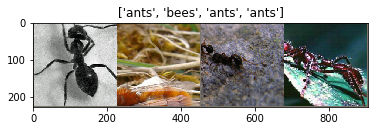

In [7]:
def imshow(input, title=None):
    """Imshow for Tensor."""
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataLoaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[classNames[x] for x in classes])

## Training the model

Now, let’s write a general function to train a model. Here, we will illustrate:

 - Scheduling the learning rate
 - Saving the best model

In [15]:
def trainModel(model, criterion, optimizer, scheduler, numOfEpochs = 25):
    since = time.time()
    
    bestModel = copy.deepcopy(model.state_dict())
    bestAcc = 0.
    
    for epoch in range(numOfEpochs):
        print('Epoch {}/{}'.format(epoch, numOfEpochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            runningLoss = 0.0
            runningCorrects = 0
            
            # Iterate over data.
            for inputs, labels in dataLoaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # FORWARD
                # track history only if train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                # statistics
                runningLoss += loss.item() * inputs.size(0)
                runningCorrects += torch.sum(preds == labels.data)
                
            epochLoss = runningLoss / datasetSizes[phase]
            epochAcc = runningCorrects.double() / datasetSizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epochLoss, epochAcc))
            
            # deep copy the model
            if phase == 'val' and epochAcc > bestAcc:
                bestAcc = epochAcc
                bestModel = copy.deepcopy(model.state_dict())
                
        print()
        
    timeElapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(timeElapsed // 60, timeElapsed % 60))
    print('Best val Acc: {:4f}'.format(bestAcc))

    # load best model weights
    model.load_state_dict(bestModel)
    return model
        

## Visualizing the model predictions

    Generic function to display predictions for a few images

In [18]:
def visualizeModel(model, numImages = 6):
    wasTraining = model.training
    model.eval()
    imagesSoFar = 0
    fig = plt.figure()
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataLoaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                imagesSoFar += 1
                ax = plt.subplot(numImages//2, 2, imagesSoFar)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classNames[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if imagesSoFar == numImages:
                    model.train(mode=wasTraining)
                    return
        model.train(mode=wasTraining)

## Finetuning the convnet
    Load a pretrained model and reset final fully connected layer.

In [13]:
modelFt = models.resnet18(pretrained=True)
numOfFeatures = modelFt.fc.in_features
modelFt.fc = nn.Linear(numOfFeatures, 2)

modelFt = modelFt.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizerFt = optim.SGD(modelFt.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
lrScheduler = lr_scheduler.StepLR(optimizerFt, step_size=7, gamma=0.1)

## Train and evaluate

In [16]:
modelFt = trainModel(modelFt, criterion, optimizerFt, lrScheduler)

Epoch 0/24
----------
train Loss: 0.5972 Acc: 0.7131
val Loss: 0.2007 Acc: 0.9216

Epoch 1/24
----------
train Loss: 0.5958 Acc: 0.7623
val Loss: 0.3259 Acc: 0.8824

Epoch 2/24
----------
train Loss: 0.4181 Acc: 0.8525
val Loss: 0.2960 Acc: 0.8889

Epoch 3/24
----------
train Loss: 0.4537 Acc: 0.7910
val Loss: 0.2842 Acc: 0.9085

Epoch 4/24
----------
train Loss: 0.7010 Acc: 0.7582
val Loss: 0.3354 Acc: 0.8627

Epoch 5/24
----------
train Loss: 0.4994 Acc: 0.8156
val Loss: 0.2253 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3856 Acc: 0.8320
val Loss: 0.1961 Acc: 0.9281

Epoch 7/24
----------
train Loss: 0.3222 Acc: 0.8525
val Loss: 0.2081 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.3594 Acc: 0.8525
val Loss: 0.1950 Acc: 0.9281

Epoch 9/24
----------
train Loss: 0.2987 Acc: 0.8566
val Loss: 0.1962 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.3745 Acc: 0.8197
val Loss: 0.1687 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.2826 Acc: 0.8566
val Loss: 0.1889 Acc: 0.9346

Ep

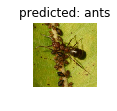

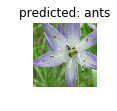

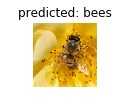

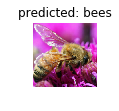

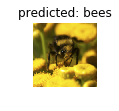

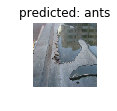

In [19]:
visualizeModel(modelFt)

##  ConvNet as fixed feature extractor
    Here, we need to freeze all the network except the final layer. We need to set requires_grad == False to freeze the parameters so that the gradients are not computed in backward().

In [21]:
modelConv = torchvision.models.resnet18(pretrained=True)
for param in modelConv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
numOfFeatures = modelConv.fc.in_features
modelConv.fc = nn.Linear(numOfFeatures, 2)

modelConv = modelConv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizerConv = optim.SGD(modelConv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
lrScheduler = lr_scheduler.StepLR(optimizerConv, step_size=7, gamma=0.1)

In [22]:
modelConv = trainModel(modelConv, criterion, optimizerConv, lrScheduler)

Epoch 0/24
----------
train Loss: 0.6879 Acc: 0.6516
val Loss: 0.8100 Acc: 0.6144

Epoch 1/24
----------
train Loss: 0.5892 Acc: 0.7172
val Loss: 0.3739 Acc: 0.8235

Epoch 2/24
----------
train Loss: 0.5154 Acc: 0.7705
val Loss: 0.4273 Acc: 0.7974

Epoch 3/24
----------
train Loss: 0.6857 Acc: 0.7705
val Loss: 0.3096 Acc: 0.8627

Epoch 4/24
----------
train Loss: 0.4457 Acc: 0.8156
val Loss: 0.1790 Acc: 0.9608

Epoch 5/24
----------
train Loss: 0.6201 Acc: 0.8033
val Loss: 0.3271 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.3111 Acc: 0.8730
val Loss: 0.1740 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3753 Acc: 0.8115
val Loss: 0.2148 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.4479 Acc: 0.8033
val Loss: 0.1673 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3240 Acc: 0.8525
val Loss: 0.1583 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.3996 Acc: 0.8402
val Loss: 0.1879 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.3989 Acc: 0.8279
val Loss: 0.1787 Acc: 0.9412

Ep

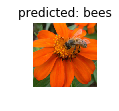

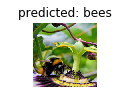

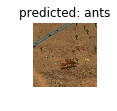

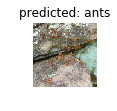

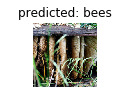

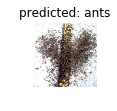

In [23]:
visualizeModel(modelConv)

plt.ioff()
plt.show()